In [ ]:
!pip install gensim

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 53.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 94.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 15.8 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: scipy
    Found existing installation: scipy 1.14.1
    Uninstalling scipy-1.14.1:
      Successfully uninstalled scipy-1.14.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.


# **Step 1: Data Combination**

We are looking at the data from three different fake news datasets. We are going to combine all of these datasets into one final dataset.

This final dataset has three columns: text, label, source.
* The text is the news segement.
* The label is true or false news. 0 label is fake news, 1 label is true news.
* The source just tells us which original dataset the text is from.

The three datasets we have combined are:
*   WELFake_Dataset
*   IOST Dataset
*  Random Fake News Dataset



In [4]:
import pandas as pd
import os

# -------- 1. WELFake_Dataset.csv --------
welfake_df = pd.read_csv('WELFake_Dataset.csv')
welfake_df = welfake_df[['text', 'label']]
welfake_df['source'] = 'WELFake'
print(f"WELFake size: {len(welfake_df)}")

# -------- 2. ISOT Dataset (True.csv & Fake.csv) --------
isot_fake = pd.read_csv('Fake.csv')
isot_fake = pd.DataFrame({'text': isot_fake['text'], 'label': 0})

isot_true = pd.read_csv('True.csv')
isot_true = pd.DataFrame({'text': isot_true['text'], 'label': 1})

isot_df = pd.concat([isot_fake, isot_true], ignore_index=True)
isot_df['source'] = 'ISOT'
print(f"ISOT size: {len(isot_df)}")

# -------- 3. Random Dataset (txt files) --------
def load_txts_from_folder(folder_path, label, source_name, top_words_only=False):
    data = []
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        if fname.endswith('.txt'):
            with open(fpath, 'r', encoding='utf-8', errors='ignore') as f:
                text = f.read().strip()
                if text:
                    if top_words_only:
                        words = text.split()
                        text = ' '.join(words[:100])
                    data.append({'text': text, 'label': label, 'source': source_name})
    return pd.DataFrame(data)

rand_fake = load_txts_from_folder(
    'Random Poltical News Dataset/Fake',
    label=0,
    source_name='Random',
    top_words_only=True
)

rand_real = load_txts_from_folder(
    'Random Poltical News Dataset/Real',
    label=1,
    source_name='Random',
    top_words_only=True
)

rand_df = pd.concat([rand_fake, rand_real], ignore_index=True)
print(f"Random Dataset size: {len(rand_df)}")

# -------- 4. Combine All (Excluding Buzzfeed) --------
final_df = pd.concat([welfake_df, isot_df, rand_df], ignore_index=True)
final_df = final_df.dropna(subset=['text'])
print(f"Final combined size: {len(final_df)}")

# -------- 5. Save to CSV --------
final_df.to_csv('final_fake_news_dataset.csv', index=False)
print("✅ Saved to final_fake_news_dataset.csv")


WELFake size: 72134
ISOT size: 44898
Random Dataset size: 150
Final combined size: 117143
✅ Saved to final_fake_news_dataset.csv


# **Step 2: Data Visualization**

Now that the data is combined we want to see if the data is balanced, seperable, and understand some of the semantics of the dataset. We use PCA and word cloud embedding to learn the distribution of data in the final combined dataset.

We can see that the dataset is fairly balanced. We are getting less samples from the random dataset though so we might want to oversample from this dataset in the future.

The PCA shows the data is not very seperable in lower dimensions but we still might be able to classify in higher dimesions. (Might indicate why logistical regression did not perform well)

The word clouds also have overlap so that means learning the semantic meaning of the word will be very important for understanding the label and this is why we want to use word2vec.

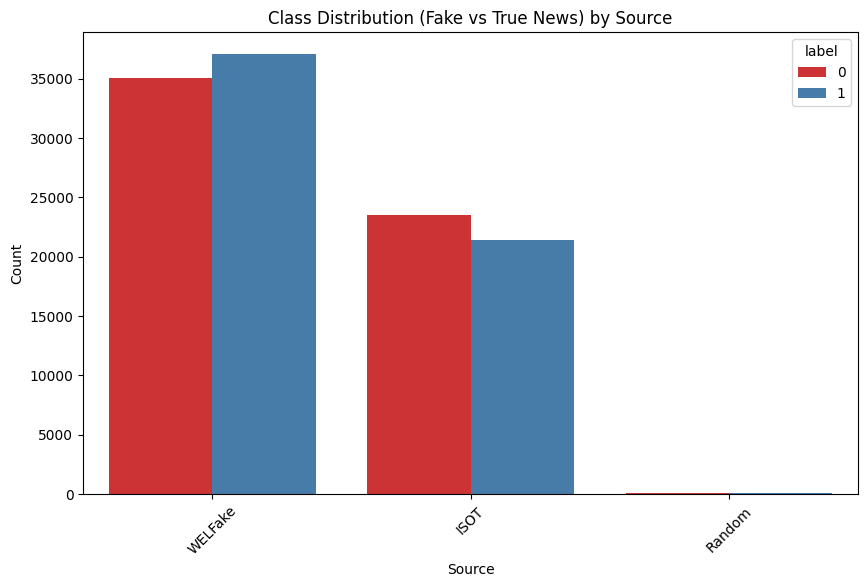

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting class distribution across sources
plt.figure(figsize=(10, 6))
sns.countplot(data=final_df, x='source', hue='label', palette='Set1')
plt.title('Class Distribution (Fake vs True News) by Source')
plt.xlabel('Source')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()


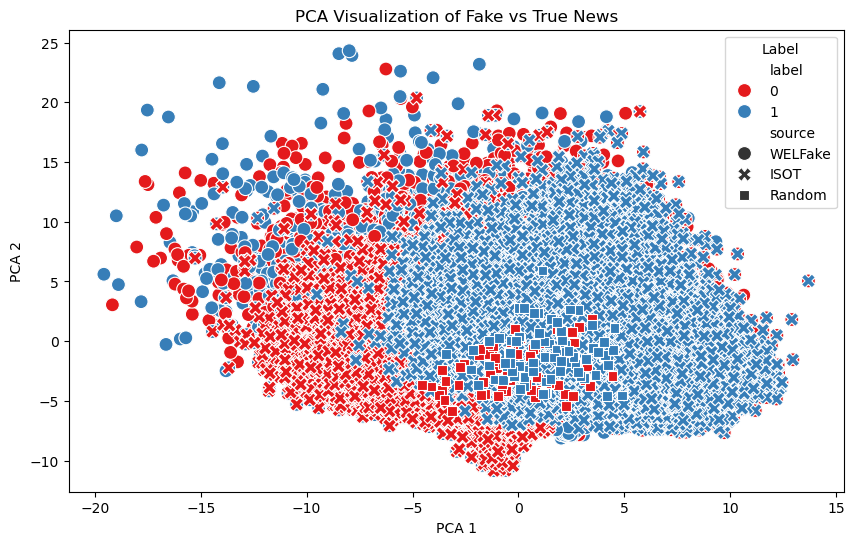

In [7]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer

# Load the final combined dataset from CSV file
final_df = pd.read_csv('final_fake_news_dataset.csv')

# TF-IDF Vectorization of the 'text' column
final_df['text'] = final_df['text'].fillna('')
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
X = vectorizer.fit_transform(final_df['text'])

# Standardize the data before applying PCA
scaler = StandardScaler(with_mean=False)
X_scaled = scaler.fit_transform(X.toarray())

# Apply PCA for dimensionality reduction
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Add the PCA results to the DataFrame
final_df['PCA1'] = X_pca[:, 0]
final_df['PCA2'] = X_pca[:, 1]

# Plotting PCA results
plt.figure(figsize=(10, 6))
sns.scatterplot(data=final_df, x='PCA1', y='PCA2', hue='label', style='source', palette='Set1', s=100)
plt.title('PCA Visualization of Fake vs True News')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.legend(title='Label', loc='upper right')
plt.show()


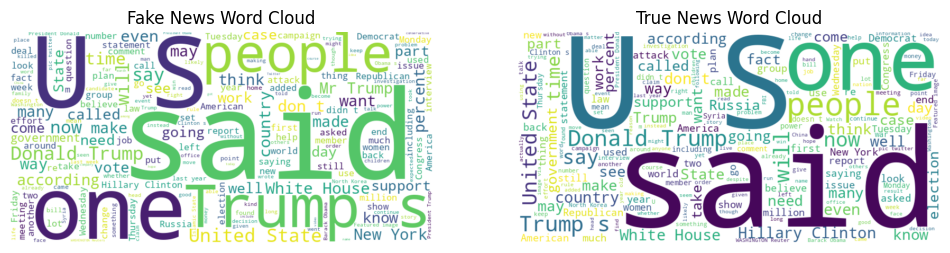

In [ ]:
from wordcloud import WordCloud

# Separate fake and true news
fake_texts = ' '.join(final_df[final_df['label'] == 0]['text'])
true_texts = ' '.join(final_df[final_df['label'] == 1]['text'])

# Generate word cloud for fake news
fake_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(fake_texts)

# Generate word cloud for true news
true_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(true_texts)

# Plot word clouds
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(fake_wordcloud, interpolation='bilinear')
plt.title('Fake News Word Cloud')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(true_wordcloud, interpolation='bilinear')
plt.title('True News Word Cloud')
plt.axis('off')

plt.show()


# **Step 3: Train Classification Models**

We are now running and traing the final classification model on the combined dataset. We are using a one hot encoding of the source feature and using word2vec for the text label. Then we are running mulitple different types of models to see which performs the best.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder
from gensim.models import Word2Vec
from scipy.sparse import hstack

# Load dataset
df = pd.read_csv('final_fake_news_dataset.csv')
df = df.dropna(subset=['text', 'source'])

# Optional: limit text to first 100 words again (safe)
df['text'] = df['text'].apply(lambda x: ' '.join(x.split()[:100]))

# -------- Word2Vec Model --------
# Tokenize the text into words (simple split)
def preprocess_text(text):
    return text.split()

# Train Word2Vec model on the text data
sentences = df['text'].apply(preprocess_text).tolist()
word2vec_model = Word2Vec(sentences, vector_size=200, window=5, min_count=1, workers=4)

# Get Word2Vec vector for each document (average of word vectors)
def get_vector(text):
    vector = []
    for word in preprocess_text(text):
        if word in word2vec_model.wv:
            vector.append(word2vec_model.wv[word])
    return np.mean(vector, axis=0) if vector else np.zeros(200)

# Apply Word2Vec to the text
X_text_vec = np.array([get_vector(text) for text in df['text']])

# -------- One-hot encode the source --------
ohe = OneHotEncoder(sparse_output=False)  # Use sparse_output=False for easy combination
X_source = ohe.fit_transform(df[['source']])

# Combine Word2Vec features and source features
X_combined = np.hstack([X_text_vec, X_source])

# Labels
y = df['label']

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X_combined, y, test_size=0.2, random_state=42, stratify=y
)

# -------- Logistic Regression --------
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)
lr_preds = lr.predict(X_test)
print(f"Logistic Regression Accuracy: {accuracy_score(y_test, lr_preds)*100:.2f}%")

# -------- XGBoost Classifier --------
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb.fit(X_train, y_train)
xgb_preds = xgb.predict(X_test)
print(f"XGBoost Accuracy: {accuracy_score(y_test, xgb_preds)*100:.2f}%")

# -------- Random Forest Classifier --------
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
rf_preds = rf.predict(X_test)
print(f"Random Forest Accuracy: {accuracy_score(y_test, rf_preds)*100:.2f}%")

Logistic Regression Accuracy: 58.05%


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [23:51:59] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Accuracy: 95.30%
Random Forest Accuracy: 92.56%


In [ ]:


import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, SGDClassifier, PassiveAggressiveClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, f1_score, balanced_accuracy_score, roc_auc_score
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from gensim.models import Word2Vec

# Load dataset
df = pd.read_csv('final_fake_news_dataset.csv')
df = df.dropna(subset=['text', 'source'])

# Limit text to first 100 words
df['text'] = df['text'].apply(lambda x: ' '.join(x.split()[:100]))

# Preprocess text
def preprocess_text(text):
    return text.split()

# Train Word2Vec model
sentences = df['text'].apply(preprocess_text).tolist()
word2vec_model = Word2Vec(sentences, vector_size=200, window=5, min_count=1, workers=4)

# Get average Word2Vec vector for each document
def get_vector(text):
    vector = []
    for word in preprocess_text(text):
        if word in word2vec_model.wv:
            vector.append(word2vec_model.wv[word])
    return np.mean(vector, axis=0) if vector else np.zeros(200)

X_text_vec = np.array([get_vector(text) for text in df['text']])

# One-hot encode 'source'
ohe = OneHotEncoder(sparse_output=False)
X_source = ohe.fit_transform(df[['source']])

# Combine Word2Vec and one-hot features
X_combined = np.hstack([X_text_vec, X_source])

# Labels
y = df['label']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_combined, y, test_size=0.2, random_state=42, stratify=y
)

# -------- Logistic Regression --------
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)
lr_preds = lr.predict(X_test)
lr_proba = lr.predict_proba(X_test)[:, 1]

print("Logistic Regression:")
print(f"  Accuracy: {accuracy_score(y_test, lr_preds)*100:.2f}%")
print(f"  F1 Score: {f1_score(y_test, lr_preds):.4f}")
print(f"  Balanced Accuracy: {balanced_accuracy_score(y_test, lr_preds):.4f}")
print(f"  AUC: {roc_auc_score(y_test, lr_proba):.4f}\n")

# -------- XGBoost Classifier --------
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb.fit(X_train, y_train)
xgb_preds = xgb.predict(X_test)
xgb_proba = xgb.predict_proba(X_test)[:, 1]

print("XGBoost:")
print(f"  Accuracy: {accuracy_score(y_test, xgb_preds)*100:.2f}%")
print(f"  F1 Score: {f1_score(y_test, xgb_preds):.4f}")
print(f"  Balanced Accuracy: {balanced_accuracy_score(y_test, xgb_preds):.4f}")
print(f"  AUC: {roc_auc_score(y_test, xgb_proba):.4f}\n")

# -------- Random Forest Classifier --------
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
rf_preds = rf.predict(X_test)
rf_proba = rf.predict_proba(X_test)[:, 1]

print("Random Forest:")
print(f"  Accuracy: {accuracy_score(y_test, rf_preds)*100:.2f}%")
print(f"  F1 Score: {f1_score(y_test, rf_preds):.4f}")
print(f"  Balanced Accuracy: {balanced_accuracy_score(y_test, rf_preds):.4f}")
print(f"  AUC: {roc_auc_score(y_test, rf_proba):.4f}\n")

# -------- Naive Bayes (MultinomialNB) --------
# Scale features to [0, 1] for MultinomialNB compatibility
scaler = MinMaxScaler()
X_nb_train = scaler.fit_transform(X_train)
X_nb_test = scaler.transform(X_test)

nb = MultinomialNB()
nb.fit(X_nb_train, y_train)
nb_preds = nb.predict(X_nb_test)
nb_proba = nb.predict_proba(X_nb_test)[:, 1]

print("Naive Bayes:")
print(f"  Accuracy: {accuracy_score(y_test, nb_preds)*100:.2f}%")
print(f"  F1 Score: {f1_score(y_test, nb_preds):.4f}")
print(f"  Balanced Accuracy: {balanced_accuracy_score(y_test, nb_preds):.4f}")
print(f"  AUC: {roc_auc_score(y_test, nb_proba):.4f}")

# -------- SGD Classifier --------
sgd = SGDClassifier(loss='log_loss', max_iter=1000, tol=1e-3, random_state=42)
sgd.fit(X_train, y_train)
sgd_preds = sgd.predict(X_test)
sgd_proba = sgd.predict_proba(X_test)[:, 1]

print("SGD Classifier:")
print(f"  Accuracy: {accuracy_score(y_test, sgd_preds)*100:.2f}%")
print(f"  F1 Score: {f1_score(y_test, sgd_preds):.4f}")
print(f"  Balanced Accuracy: {balanced_accuracy_score(y_test, sgd_preds):.4f}")
print(f"  AUC: {roc_auc_score(y_test, sgd_proba):.4f}\n")

# -------- Passive Aggressive Classifier --------
pac = PassiveAggressiveClassifier(max_iter=1000, tol=1e-3, random_state=42)
pac.fit(X_train, y_train)
pac_preds = pac.predict(X_test)

# This classifier does not support predict_proba
# So we’ll skip AUC and only print others
print("Passive Aggressive Classifier:")
print(f"  Accuracy: {accuracy_score(y_test, pac_preds)*100:.2f}%")
print(f"  F1 Score: {f1_score(y_test, pac_preds):.4f}")
print(f"  Balanced Accuracy: {balanced_accuracy_score(y_test, pac_preds):.4f}")
print(f"  AUC: Not available (no probability output)\n")

'''
# -------- Support Vector Machine (SVM) --------
svm = SVC(kernel='linear', probability=True)
svm.fit(X_train, y_train)
svm_preds = svm.predict(X_test)
svm_proba = svm.predict_proba(X_test)[:, 1]

print("SVM (Linear Kernel):")
print(f"  Accuracy: {accuracy_score(y_test, svm_preds)*100:.2f}%")
print(f"  F1 Score: {f1_score(y_test, svm_preds):.4f}")
print(f"  Balanced Accuracy: {balanced_accuracy_score(y_test, svm_preds):.4f}")
print(f"  AUC: {roc_auc_score(y_test, svm_proba):.4f}\n")
'''

Logistic Regression:
  Accuracy: 57.88%
  F1 Score: 0.5731
  Balanced Accuracy: 0.5788
  AUC: 0.6331



/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:55:38] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost:
  Accuracy: 95.20%
  F1 Score: 0.9522
  Balanced Accuracy: 0.9520
  AUC: 0.9911

Random Forest:
  Accuracy: 92.80%
  F1 Score: 0.9284
  Balanced Accuracy: 0.9280
  AUC: 0.9793

Naive Bayes:
  Accuracy: 57.24%
  F1 Score: 0.5853
  Balanced Accuracy: 0.5724
  AUC: 0.5734
SGD Classifier:
  Accuracy: 57.33%
  F1 Score: 0.4788
  Balanced Accuracy: 0.5732
  AUC: 0.6308

Passive Aggressive Classifier:
  Accuracy: 49.87%
  F1 Score: 0.6648
  Balanced Accuracy: 0.4988
  AUC: Not available (no probability output)



'\n# -------- Support Vector Machine (SVM) --------\nsvm = SVC(kernel=\'linear\', probability=True)\nsvm.fit(X_train, y_train)\nsvm_preds = svm.predict(X_test)\nsvm_proba = svm.predict_proba(X_test)[:, 1]\n\nprint("SVM (Linear Kernel):")\nprint(f"  Accuracy: {accuracy_score(y_test, svm_preds)*100:.2f}%")\nprint(f"  F1 Score: {f1_score(y_test, svm_preds):.4f}")\nprint(f"  Balanced Accuracy: {balanced_accuracy_score(y_test, svm_preds):.4f}")\nprint(f"  AUC: {roc_auc_score(y_test, svm_proba):.4f}\n")\n'

In [ ]:


import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import f1_score, balanced_accuracy_score, roc_auc_score, accuracy_score

class FakeNewsNN(nn.Module):
    def __init__(self, input_size):
        super(FakeNewsNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 256)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(256, 64)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(64, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.fc3(out)
        out = self.sigmoid(out)
        return out

# Convert numpy arrays to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)

# Create datasets and dataloaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

input_size = X_train.shape[1]
model = FakeNewsNN(input_size)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Training loop
epochs = 15
for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}")

model.eval()
with torch.no_grad():
    y_pred_proba = model(X_test_tensor).squeeze().numpy()
    y_pred = (y_pred_proba >= 0.5).astype(int)

print("Neural Network:")
print(f"  Accuracy: {accuracy_score(y_test, y_pred)*100:.2f}%")
print(f"  F1 Score: {f1_score(y_test, y_pred):.4f}")
print(f"  Balanced Accuracy: {balanced_accuracy_score(y_test, y_pred):.4f}")
print(f"  AUC: {roc_auc_score(y_test, y_pred_proba):.4f}")

Epoch 1/15, Loss: 1078.2610
Epoch 2/15, Loss: 368.7743
Epoch 3/15, Loss: 334.3565
Epoch 4/15, Loss: 311.2699
Epoch 5/15, Loss: 336.0992
Epoch 6/15, Loss: 349.1484
Epoch 7/15, Loss: 293.6289
Epoch 8/15, Loss: 277.9676
Epoch 9/15, Loss: 331.7827
Epoch 10/15, Loss: 283.9665
Epoch 11/15, Loss: 278.1147
Epoch 12/15, Loss: 293.4321
Epoch 13/15, Loss: 302.4660
Epoch 14/15, Loss: 265.3968
Epoch 15/15, Loss: 265.5296
Neural Network:
  Accuracy: 96.26%
  F1 Score: 0.9629
  Balanced Accuracy: 0.9626
  AUC: 0.9952
